In [85]:
import copy

import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

In [86]:
data = pd.read_csv('../../Data/processed/df_scaled.csv')
X = data.iloc[:, 0:27]
y = data.iloc[:, 27]

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [87]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [88]:
class Deep(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(27, 64)
        self.act1 = torch.nn.Tanh()
        self.layer2 = torch.nn.Linear(64, 128)
        self.act2 = torch.nn.Tanh()
        self.layer3 = torch.nn.Linear(128, 64)
        self.act3 = torch.nn.Tanh()
        self.output = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [89]:
model = Deep()
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

18433


In [90]:
def model_train(model, X_train, y_train, X_val, y_val):

    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    n_epochs = 20
    batch_size = 32
    batch_start = torch.arange(0, len(X_train), batch_size)

    best_acc = - np.inf
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    return best_acc

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.325, shuffle=True)

In [92]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X_train, y_train):
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores.append(acc)

Accuracy (deep): 0.82
Accuracy (deep): 0.80
Accuracy (deep): 0.98
Accuracy (deep): 0.82
Accuracy (deep): 0.90


In [93]:
deep_acc = np.mean(cv_scores)
deep_std = np.std(cv_scores)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Deep: 86.50% (+/- 6.44%)


[ 1.0468676  -0.3774685   1.1876298  -0.4114503  -0.81209457  1.4359163
  0.6394703  -0.72197604 -0.69109476  0.69109476 -0.9571463  -0.44450045
  1.6057127  -0.28972676  0.05812382  0.43905705 -0.9833043   1.0101526
 -0.11684125 -1.5923927  -0.9379482   1.0806865  -0.27583864  0.8407714
 -0.25400025 -1.1104425   1.2580178 ] -> [0.5233821] (expected [1.])
[-1.1668717  -0.09550637 -0.2764434  -0.4114503   1.2837092   1.4359163
 -0.56311566 -0.72197604 -0.69109476  0.69109476 -0.9571463  -0.44450045
  1.6057127  -0.28972676  0.05812382  0.43905705 -0.9833043   1.0101526
 -0.11684125  0.62798584  1.066157   -0.9253378  -0.27583864  0.8407714
 -0.25400025  0.90054184 -0.7949013 ] -> [0.41019517] (expected [0.])
[ 1.3789285  -0.9413928   6.099981   -0.4114503   0.45412022 -0.6964194
  0.46767232 -0.72197604  1.4469796  -1.4469796  -0.9571463  -0.44450045
  1.6057127  -0.28972676  0.05812382  0.43905705  1.0169791  -0.98994946
 -0.11684125  0.62798584 -0.9379482   1.0806865  -0.27583864  0.8

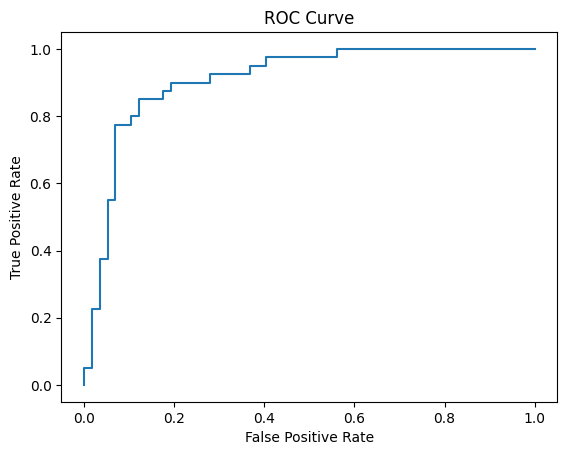

In [94]:
model.eval()
with torch.no_grad():
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [95]:
y_pred[0:5]

tensor([[0.5234],
        [0.4102],
        [0.4614],
        [0.5235],
        [0.5597]])

In [96]:
# Convert values in y_pred: 0.5 or greater to 1, less than 0.5 to 0
y_pred = [[1 if value >= 0.5 else 0 for value in sublist] for sublist in y_pred]

In [97]:
len(y_test)

97

In [98]:
confusion_matrix(y_test, y_pred)

array([[49,  8],
       [ 6, 34]])

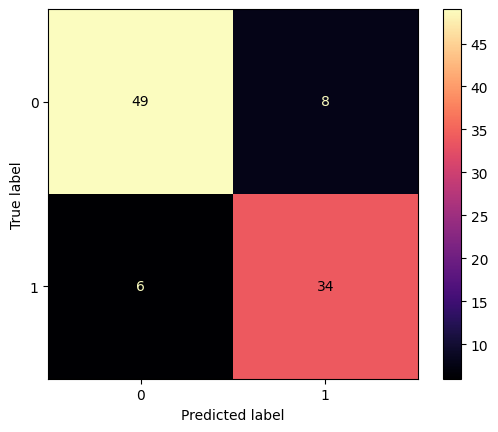

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap = 'magma')

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88        57
         1.0       0.81      0.85      0.83        40

    accuracy                           0.86        97
   macro avg       0.85      0.85      0.85        97
weighted avg       0.86      0.86      0.86        97

